# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

### 1.2 Load the dataset and visualize an example

In [1]:
import pickle
import cv2
import numpy as np
import os
import time

pre_seq_length = 12
aft_seq_length = 12

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channels, height and width  of each frame

(899, 12, 1, 144, 144)


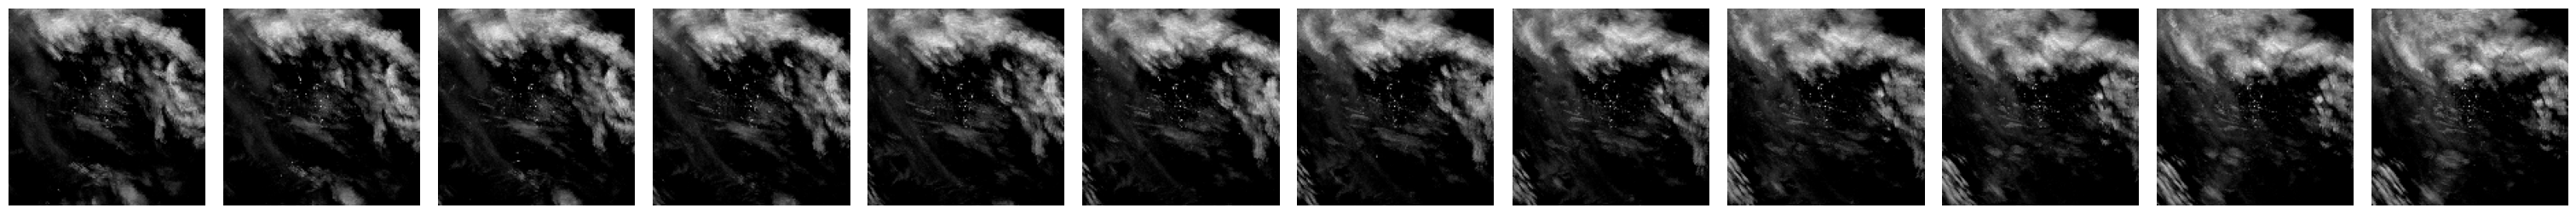

In [2]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

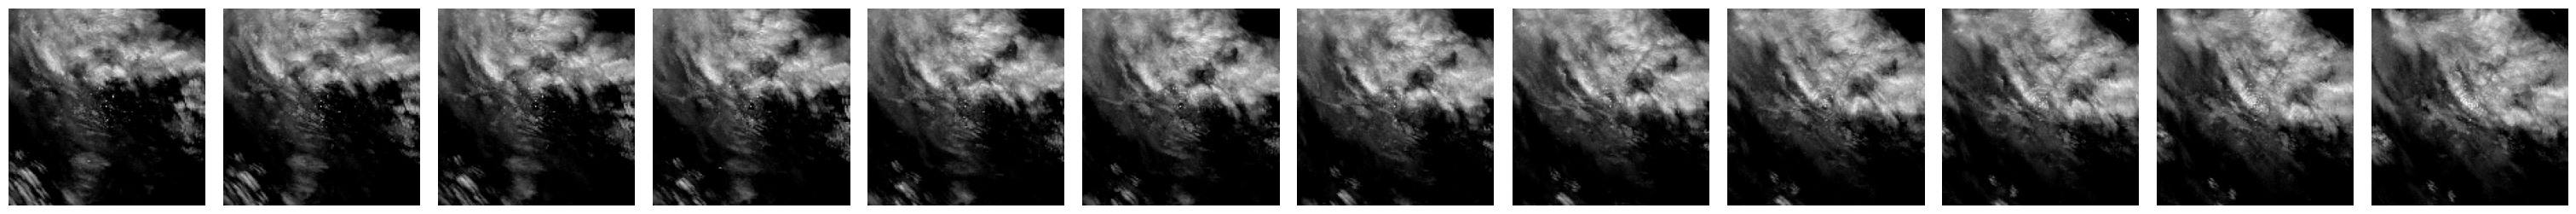

In [3]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [4]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name = "custom"):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [5]:
batch_size = 8

In [6]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [7]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [8]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': 1,
    'epoch': 50,
    'lr': 0.001,   
    'metrics': ['mae', 'mse', 'rmse', 'ssim', 'psnr', 'snr', 'lpips'],   # ['mae', 'mse', 'rmse', 'ssim', 'psnr', 'snr', 'lpips']
    'drop_path': 0,
    'sched': 'onecycle',

    "num_workers": 	8,
    "warmup_epoch": 	5,
    "warmup_lr": 	1e-06,
    
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [12, 1, 144, 144],
}

custom_model_config = {
    'method': 'SimVP', #SimVP #PredRNNv2 # MMVP #SwinLSTM #WaST
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py', there are example for all models parameters in /configs

    #loss function for simVP models, tau, phydnet
    'loss': 'weightmsce', # 'mse', 'mae', 'weight', 'msce', 'weightmsce', vggperceptual
    
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    
    # Here, we directly set these parameters
    'model_type': 'swin', #Swin #MogaNET 
    'N_S': 2, #4
    'N_T': 8, #8
    'hid_S': 32, #64
    'hid_T': 256, #512
    'spatio_kernel_enc': 3,
    'spatio_kernel_dec': 3,
    
    # #PredRNNv2
    # 'num_hidden': '128,128,128,128',
    # 'filter_size': 5,
    # 'stride': 1,
    # 'patch_size': 2,
    # 'layer_norm': 0,
    # 'decouple_beta': 0.1,
    # 'reverse_scheduled_sampling': 1,
    # 'r_sampling_step_1': 25000,
    # 'r_sampling_step_2': 50000,
    # 'r_exp_alpha': 5000,
    # # scheduled sampling
    # 'scheduled_sampling': 1,
    # 'sampling_stop_iter': 50000,
    # 'sampling_start_value': 1.0,
    # 'sampling_changing_rate': 0.00002
    
    
    # # WaST
    # 'encoder_dim': 20,
    # 'block_list': [2, 8, 2],
    # 'mlp_ratio': 4.0,
    # 'loss_weight': 0.001,
    
    # #MMVP
    # "downsample_setting": '2,2,2',
    # "hid_S": 16,
    # "hid_T": 96,
    # "rrdb_encoder_num": 2,
    # "rrdb_decoder_num": 2
    
    # # SwinLSTM
    # "depths": 6,
    # "num_heads": 4,
    # "patch_size": 2,
    # "window_size": 4,
    # "embed_dim": 128
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [9]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test),strategy="dp")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [10]:
torch.set_float32_matmul_precision('high')  #Choose matrix mutiplication precision between "highest" "high" "medium"

print('>'*35 + ' training ' + '<'*35)
start_time = time.time()
exp.train()
train_time = time.time() - start_time
print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimVP_Model    | 12.4 M
1 | criterion | WeightMSCELoss | 0     
---------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.671    Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: win32
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:33) [MSC v.1929 64 bit (AMD64)]
CUDA available: True
CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3
NVCC: Not Available
GPU 0: NVIDIA GeForce RTX 4080
GCC: <built-in method strip of str object at 0x00000229705A9170>
PyTorch: 2.1.0
PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-ge

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 113: 'val_loss' reached 0.03763 (best 0.03763), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=00-val_loss=0.038.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 226: 'val_loss' reached 0.03351 (best 0.03351), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=01-val_loss=0.034.ckpt' as top 1


Epoch 1: Lr: 0.0000400 | Train Loss: 0.0463520 | Vali Loss: 0.0335116


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 339: 'val_loss' reached 0.03147 (best 0.03147), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=02-val_loss=0.031.ckpt' as top 1


Epoch 2: Lr: 0.0000400 | Train Loss: 0.0318296 | Vali Loss: 0.0314709


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 452: 'val_loss' reached 0.02990 (best 0.02990), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=03-val_loss=0.030.ckpt' as top 1


Epoch 3: Lr: 0.0000400 | Train Loss: 0.0283782 | Vali Loss: 0.0299009


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 565: 'val_loss' reached 0.02785 (best 0.02785), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=04-val_loss=0.028.ckpt' as top 1


Epoch 4: Lr: 0.0000400 | Train Loss: 0.0263155 | Vali Loss: 0.0278466


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 678: 'val_loss' reached 0.02695 (best 0.02695), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=05-val_loss=0.027.ckpt' as top 1


Epoch 5: Lr: 0.0000400 | Train Loss: 0.0248611 | Vali Loss: 0.0269515


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 791: 'val_loss' reached 0.02620 (best 0.02620), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=06-val_loss=0.026.ckpt' as top 1


Epoch 6: Lr: 0.0000400 | Train Loss: 0.0238325 | Vali Loss: 0.0261970


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 904: 'val_loss' reached 0.02566 (best 0.02566), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=07-val_loss=0.026.ckpt' as top 1


Epoch 7: Lr: 0.0000400 | Train Loss: 0.0228831 | Vali Loss: 0.0256571


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1017: 'val_loss' reached 0.02521 (best 0.02521), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=08-val_loss=0.025.ckpt' as top 1


Epoch 8: Lr: 0.0000401 | Train Loss: 0.0221660 | Vali Loss: 0.0252078


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1130: 'val_loss' reached 0.02468 (best 0.02468), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=09-val_loss=0.025.ckpt' as top 1


Epoch 9: Lr: 0.0000401 | Train Loss: 0.0216314 | Vali Loss: 0.0246780


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1243: 'val_loss' reached 0.02427 (best 0.02427), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=10-val_loss=0.024.ckpt' as top 1


Epoch 10: Lr: 0.0000401 | Train Loss: 0.0212700 | Vali Loss: 0.0242720


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1356: 'val_loss' was not in top 1


Epoch 11: Lr: 0.0000401 | Train Loss: 0.0208862 | Vali Loss: 0.0244880


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1469: 'val_loss' reached 0.02397 (best 0.02397), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=12-val_loss=0.024.ckpt' as top 1


Epoch 12: Lr: 0.0000401 | Train Loss: 0.0207357 | Vali Loss: 0.0239658


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1582: 'val_loss' reached 0.02396 (best 0.02396), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=13-val_loss=0.024.ckpt' as top 1


Epoch 13: Lr: 0.0000401 | Train Loss: 0.0205862 | Vali Loss: 0.0239573


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1695: 'val_loss' reached 0.02365 (best 0.02365), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=14-val_loss=0.024.ckpt' as top 1


Epoch 14: Lr: 0.0000402 | Train Loss: 0.0203891 | Vali Loss: 0.0236502


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1808: 'val_loss' reached 0.02362 (best 0.02362), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=15-val_loss=0.024.ckpt' as top 1


Epoch 15: Lr: 0.0000402 | Train Loss: 0.0203332 | Vali Loss: 0.0236203


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1921: 'val_loss' was not in top 1


Epoch 16: Lr: 0.0000402 | Train Loss: 0.0200467 | Vali Loss: 0.0240952


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 2034: 'val_loss' was not in top 1


Epoch 17: Lr: 0.0000402 | Train Loss: 0.0200291 | Vali Loss: 0.0236416


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 2147: 'val_loss' reached 0.02346 (best 0.02346), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=18-val_loss=0.023.ckpt' as top 1


Epoch 18: Lr: 0.0000403 | Train Loss: 0.0198812 | Vali Loss: 0.0234562


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2260: 'val_loss' reached 0.02334 (best 0.02334), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=19-val_loss=0.023.ckpt' as top 1


Epoch 19: Lr: 0.0000403 | Train Loss: 0.0197346 | Vali Loss: 0.0233424


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2373: 'val_loss' was not in top 1


Epoch 20: Lr: 0.0000403 | Train Loss: 0.0196435 | Vali Loss: 0.0237553


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2486: 'val_loss' was not in top 1


Epoch 21: Lr: 0.0000404 | Train Loss: 0.0195470 | Vali Loss: 0.0234732


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2599: 'val_loss' reached 0.02331 (best 0.02331), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=22-val_loss=0.023.ckpt' as top 1


Epoch 22: Lr: 0.0000404 | Train Loss: 0.0195644 | Vali Loss: 0.0233102


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2712: 'val_loss' reached 0.02331 (best 0.02331), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=23-val_loss=0.023.ckpt' as top 1


Epoch 23: Lr: 0.0000404 | Train Loss: 0.0194378 | Vali Loss: 0.0233054


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2825: 'val_loss' reached 0.02314 (best 0.02314), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=24-val_loss=0.023.ckpt' as top 1


Epoch 24: Lr: 0.0000405 | Train Loss: 0.0194222 | Vali Loss: 0.0231416


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2938: 'val_loss' was not in top 1


Epoch 25: Lr: 0.0000405 | Train Loss: 0.0194069 | Vali Loss: 0.0235944


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 3051: 'val_loss' reached 0.02306 (best 0.02306), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=26-val_loss=0.023.ckpt' as top 1


Epoch 26: Lr: 0.0000406 | Train Loss: 0.0193921 | Vali Loss: 0.0230587


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 3164: 'val_loss' was not in top 1


Epoch 27: Lr: 0.0000406 | Train Loss: 0.0192319 | Vali Loss: 0.0230897


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 3277: 'val_loss' was not in top 1


Epoch 28: Lr: 0.0000406 | Train Loss: 0.0191195 | Vali Loss: 0.0234297


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3390: 'val_loss' was not in top 1


Epoch 29: Lr: 0.0000407 | Train Loss: 0.0191207 | Vali Loss: 0.0233076


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3503: 'val_loss' reached 0.02292 (best 0.02292), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=30-val_loss=0.023.ckpt' as top 1


Epoch 30: Lr: 0.0000407 | Train Loss: 0.0192494 | Vali Loss: 0.0229197


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3616: 'val_loss' was not in top 1


Epoch 31: Lr: 0.0000408 | Train Loss: 0.0191096 | Vali Loss: 0.0229334


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3729: 'val_loss' reached 0.02276 (best 0.02276), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=32-val_loss=0.023.ckpt' as top 1


Epoch 32: Lr: 0.0000408 | Train Loss: 0.0189435 | Vali Loss: 0.0227551


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3842: 'val_loss' was not in top 1


Epoch 33: Lr: 0.0000409 | Train Loss: 0.0188552 | Vali Loss: 0.0229062


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3955: 'val_loss' was not in top 1


Epoch 34: Lr: 0.0000410 | Train Loss: 0.0188988 | Vali Loss: 0.0233739


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 4068: 'val_loss' was not in top 1


Epoch 35: Lr: 0.0000410 | Train Loss: 0.0187780 | Vali Loss: 0.0230293


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 4181: 'val_loss' was not in top 1


Epoch 36: Lr: 0.0000411 | Train Loss: 0.0188477 | Vali Loss: 0.0230584


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 4294: 'val_loss' was not in top 1


Epoch 37: Lr: 0.0000411 | Train Loss: 0.0186893 | Vali Loss: 0.0229735


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 4407: 'val_loss' was not in top 1


Epoch 38: Lr: 0.0000412 | Train Loss: 0.0187300 | Vali Loss: 0.0237468


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4520: 'val_loss' was not in top 1


Epoch 39: Lr: 0.0000413 | Train Loss: 0.0186052 | Vali Loss: 0.0228462


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4633: 'val_loss' was not in top 1


Epoch 40: Lr: 0.0000413 | Train Loss: 0.0186604 | Vali Loss: 0.0228397


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4746: 'val_loss' was not in top 1


Epoch 41: Lr: 0.0000414 | Train Loss: 0.0185154 | Vali Loss: 0.0229969


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4859: 'val_loss' was not in top 1


Epoch 42: Lr: 0.0000415 | Train Loss: 0.0185437 | Vali Loss: 0.0229989


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4972: 'val_loss' was not in top 1


Epoch 43: Lr: 0.0000415 | Train Loss: 0.0185994 | Vali Loss: 0.0229709


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 5085: 'val_loss' was not in top 1


Epoch 44: Lr: 0.0000416 | Train Loss: 0.0184145 | Vali Loss: 0.0229024


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 5198: 'val_loss' was not in top 1


Epoch 45: Lr: 0.0000417 | Train Loss: 0.0183009 | Vali Loss: 0.0230420


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 5311: 'val_loss' was not in top 1


Epoch 46: Lr: 0.0000417 | Train Loss: 0.0183407 | Vali Loss: 0.0230339


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 5424: 'val_loss' was not in top 1


Epoch 47: Lr: 0.0000418 | Train Loss: 0.0182583 | Vali Loss: 0.0235189


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 5537: 'val_loss' was not in top 1


Epoch 48: Lr: 0.0000419 | Train Loss: 0.0182363 | Vali Loss: 0.0230603


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5650: 'val_loss' was not in top 1


Epoch 49: Lr: 0.0000420 | Train Loss: 0.0182367 | Vali Loss: 0.0228873


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Testing: 0it [00:00, ?it/s]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Aleja\anaconda3\envs\openstl_weather\lib\site-packages\lpips\weights\v0.1\alex.pth
mse:77.15203857421875, mae:643.344482421875, rmse:8.783623695373535, ssim:0.7574716280616912, psnr:27.425524729780157, snr:4.83285015451996, lpips:0.3305815787451273


### 4 Saving visualisation, metrics and model parameters

In [11]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load(f'./work_dirs/custom_exp/saved/inputs_{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs.npy')
preds = np.load(f'./work_dirs/custom_exp/saved/preds_{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs.npy')
trues = np.load(f'./work_dirs/custom_exp/saved/trues_{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs.npy')

In [12]:
# import matplotlib.pyplot as plt 

# # Save images for model comparison 

# indices= 65,102,138,139,160,161     # Images chosen for model comparison


# if not os.path.exists('work_dirs/custom_exp/models'):
#    os.makedirs('work_dirs/custom_exp/models')

# for index in indices:
#     fig, axs = plt.subplots(1, 12, figsize=(100,100))
#     test_data = test_set[index][0][None,:]
#     vmax = torch.max(test_set[index][0])
    
#     # Save input images
#     for i in range(12):
#         axs[i].imshow(test_data[0][i][0],vmin=0, vmax=vmax)
#         axs[i].axis('off')
#     plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}inputs.jpg",bbox_inches='tight')

#     # Save true images
#     fig, axs = plt.subplots(1, 12, figsize=(100,100))

#     for i in range(12):
#         axs[i].imshow(test_set[index][1][i][0],vmin=0, vmax=vmax)
#         axs[i].axis('off')
#     plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}trues.jpg",bbox_inches='tight')

#     # Save predicted images
#     fig, axs = plt.subplots(1, 12, figsize=(100,100))
#     test_data = test_data.to("cuda:0")

#     with torch.no_grad():
#         pred = exp.method.model(test_data.to("cpu"))
#         pred = pred.to("cpu")

#     for i in range(12):
#         axs[i].imshow(pred[0][i][0],vmin=0, vmax=vmax)
#         axs[i].axis('off')
#     plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}preds.jpg",bbox_inches='tight')

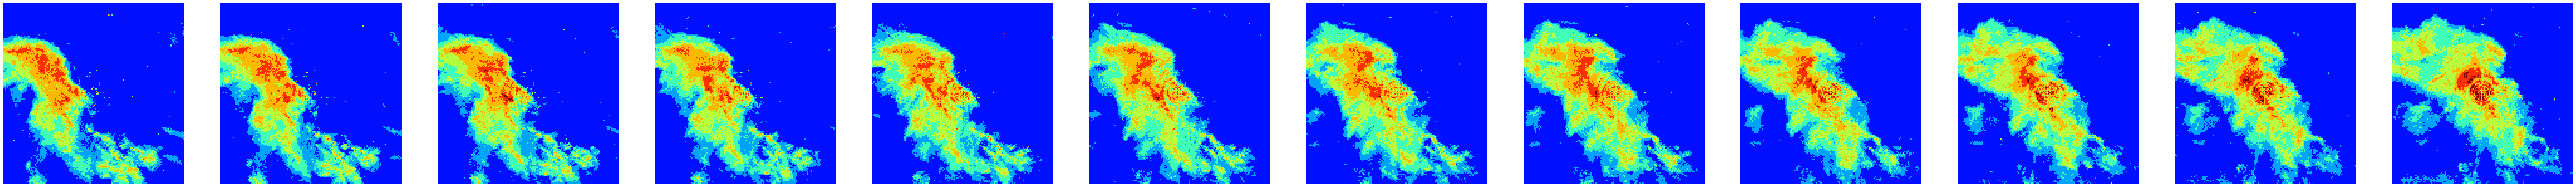

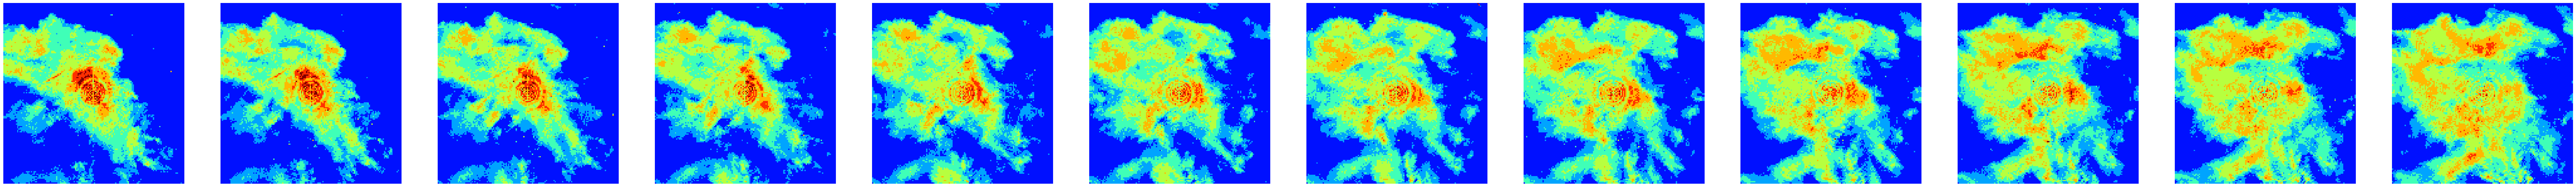

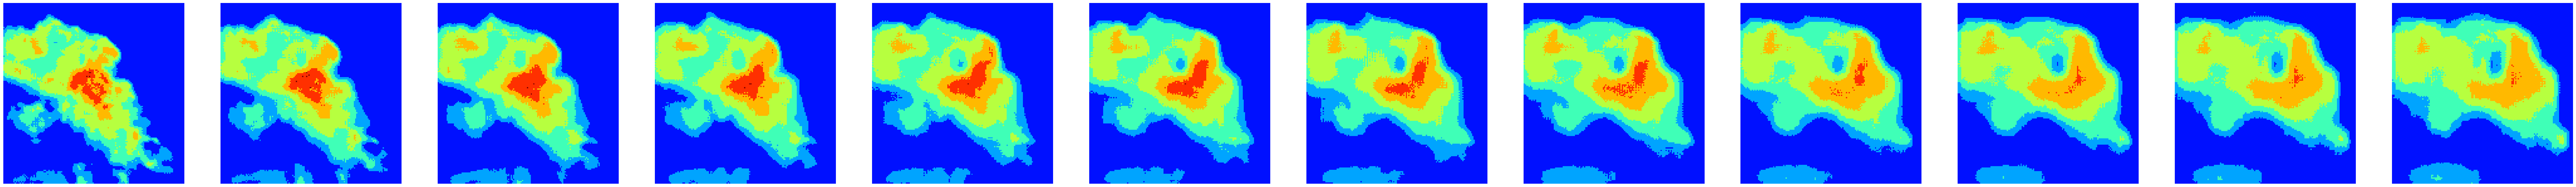

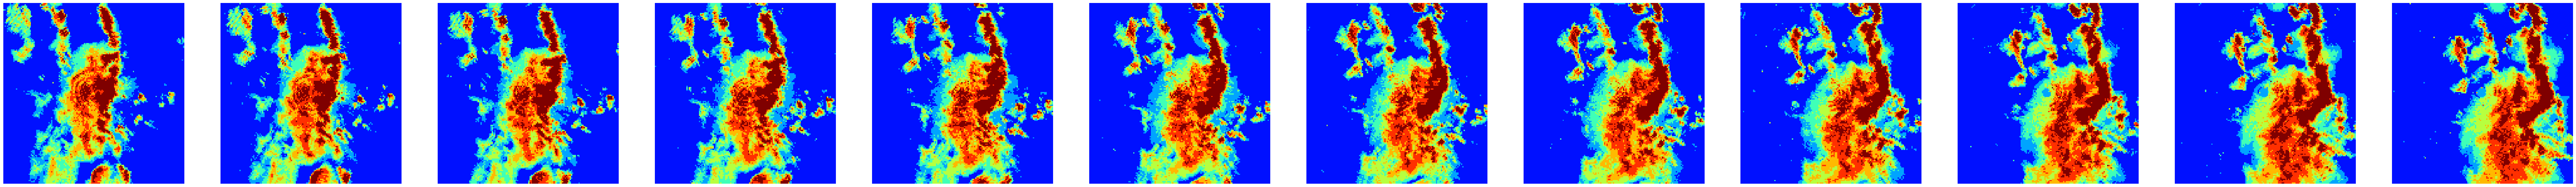

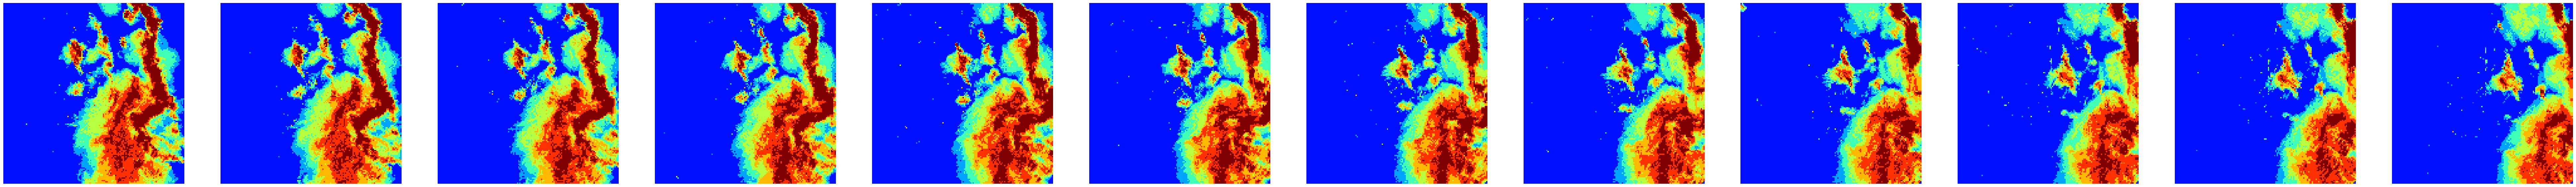

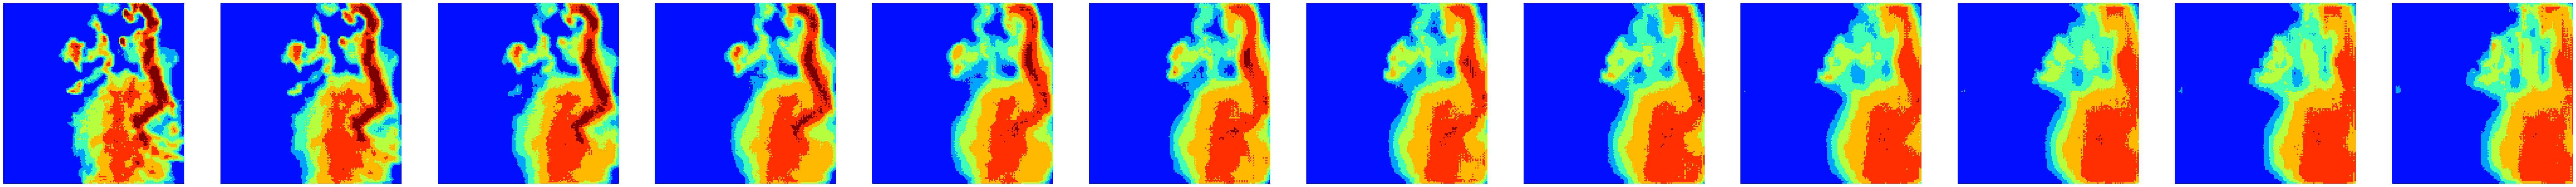

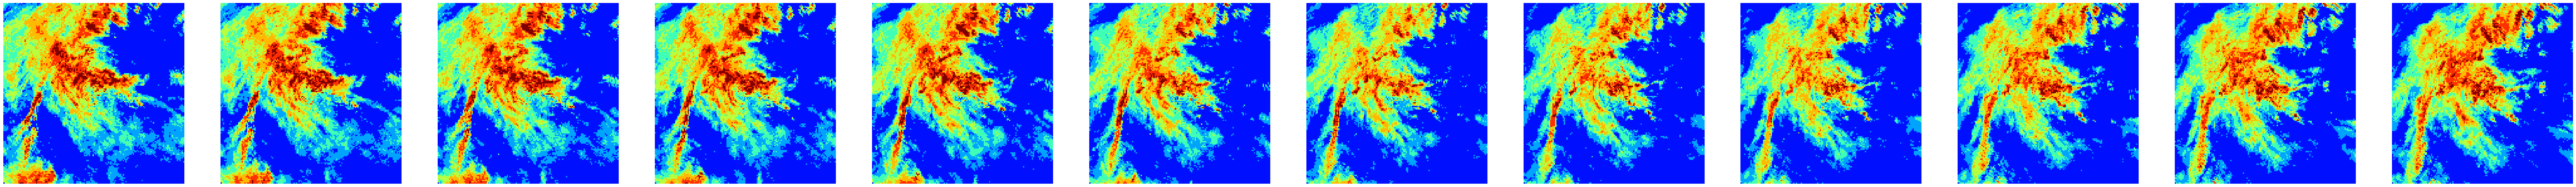

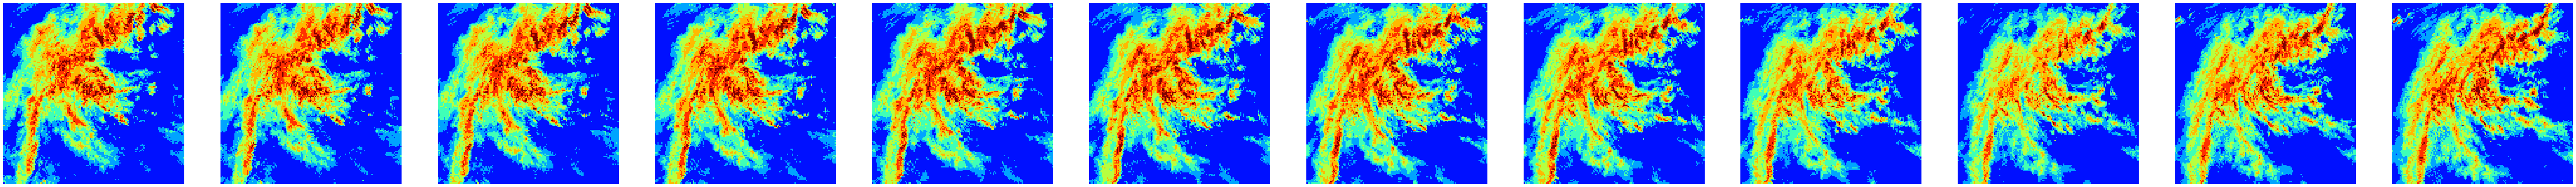

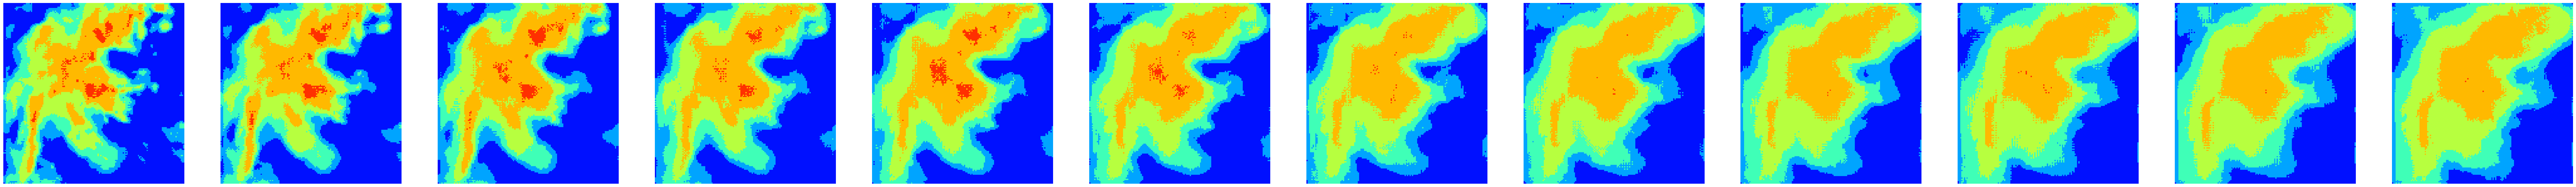

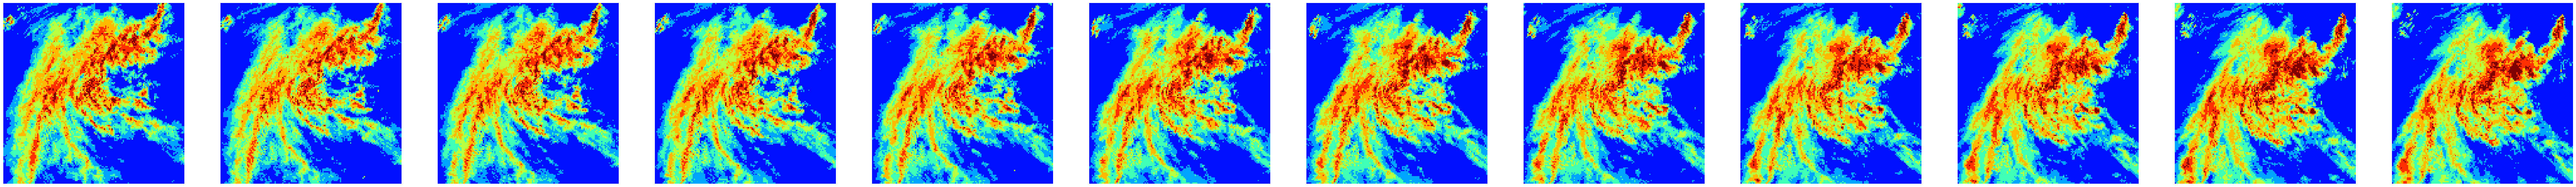

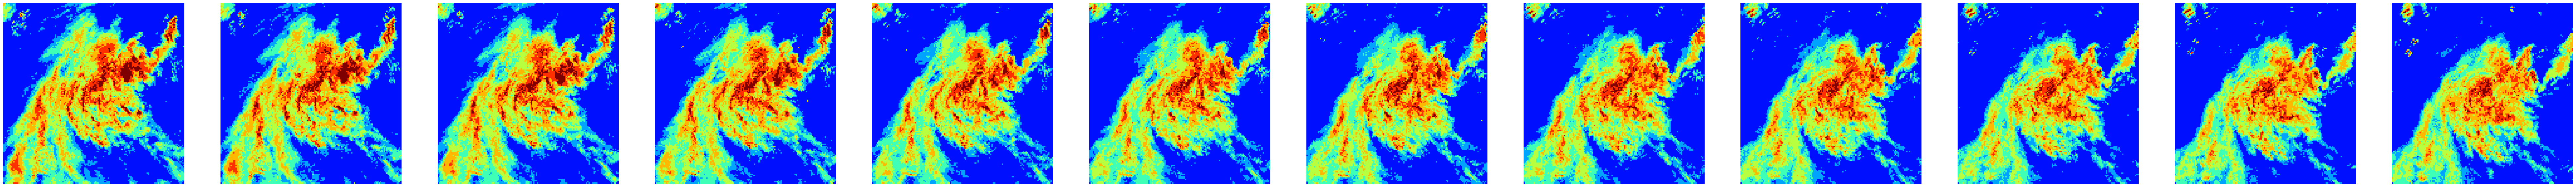

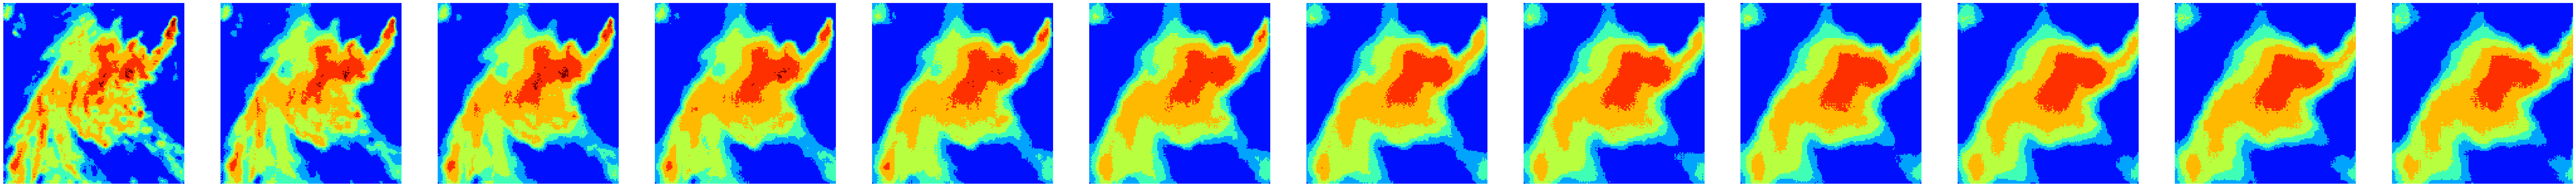

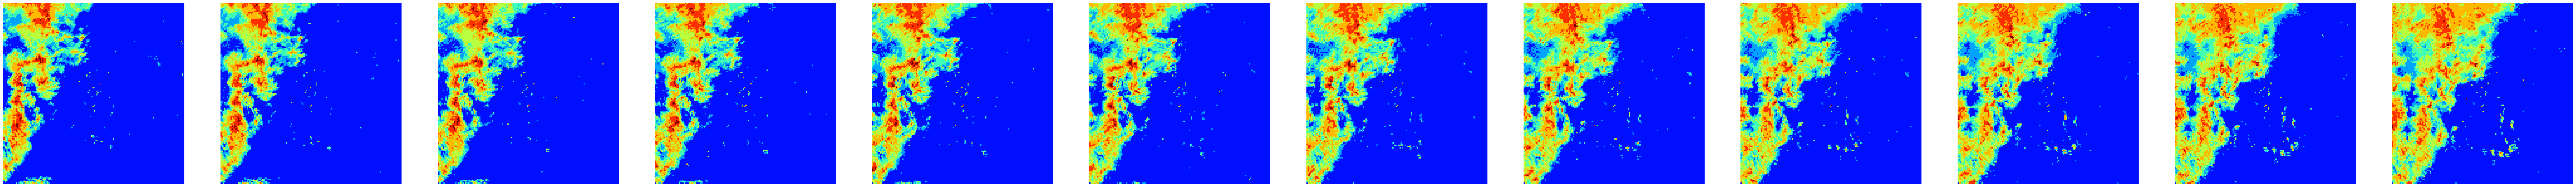

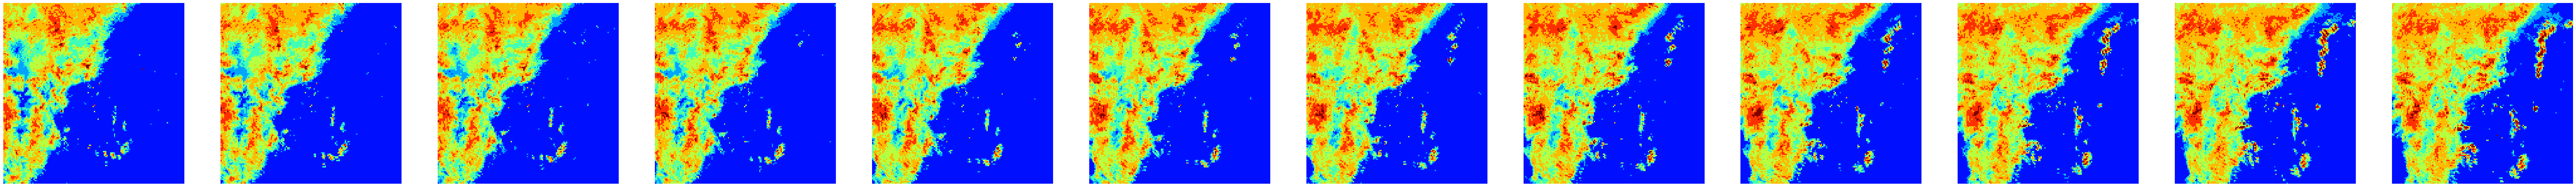

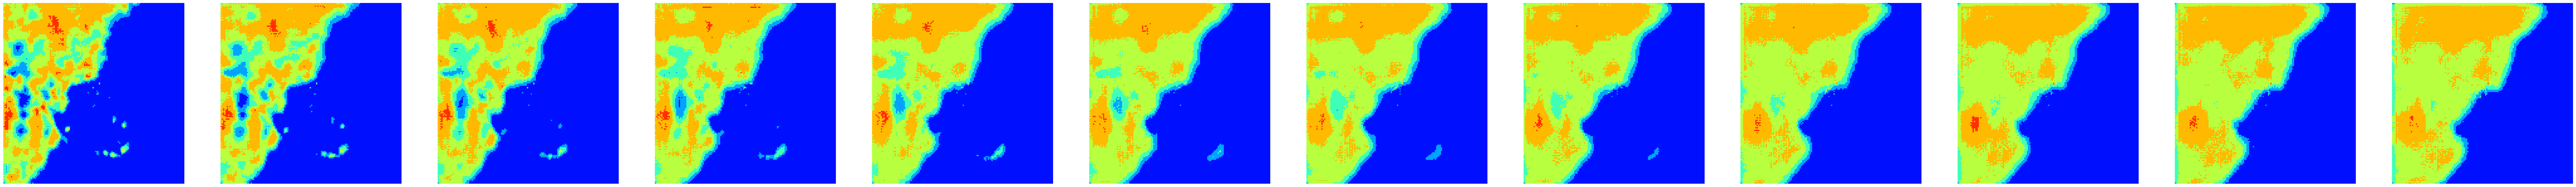

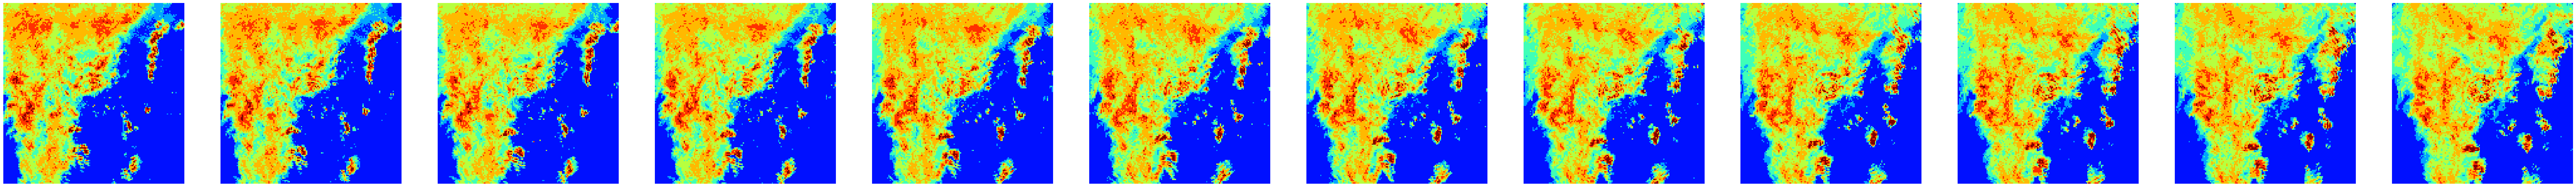

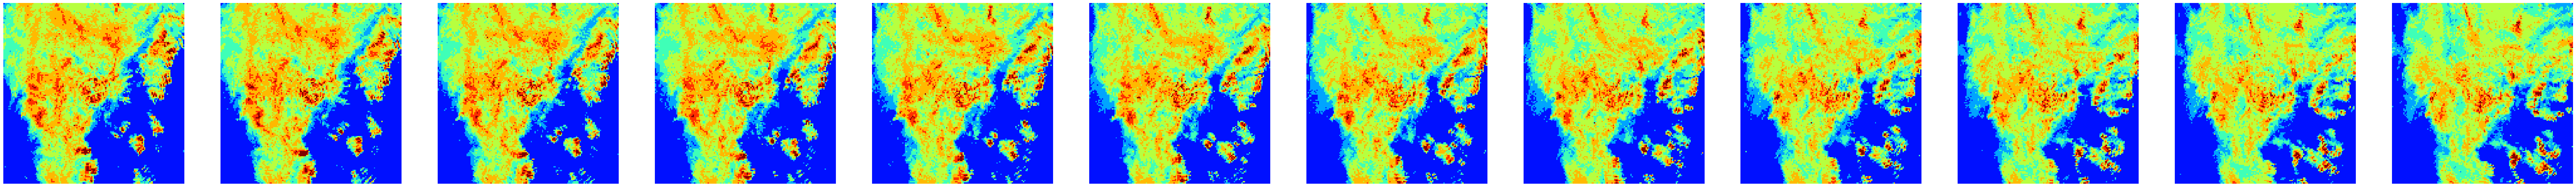

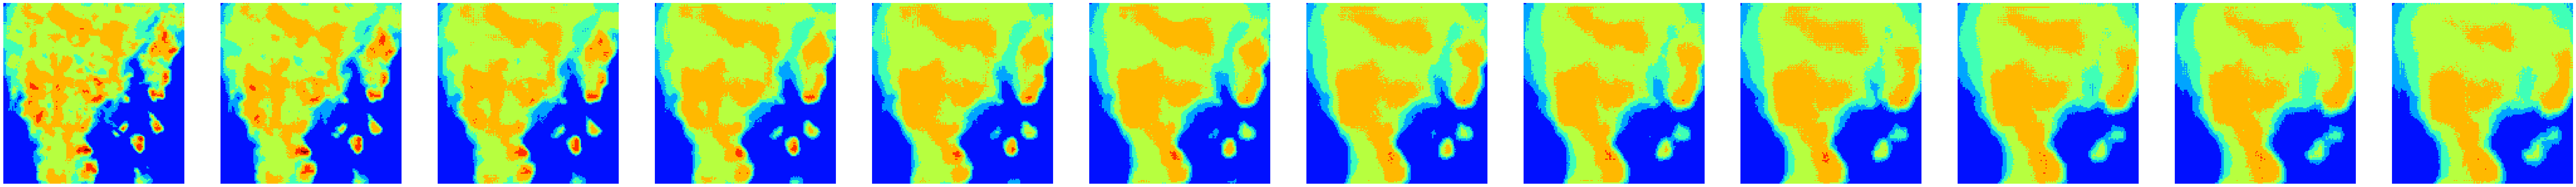

In [13]:
import matplotlib.pyplot as plt 

# Classify images into 7 groups of reflectivities
def classify_image(image_tensor):
    # Define the ranges for classification
    ranges = [10., 15., 20., 25., 30., 35., 40., 45., 70.]

    # Initialize an empty tensor to store the classification results
    classified_tensor = torch.zeros_like(image_tensor, dtype=torch.long)

    # Iterate over the ranges and assign class labels based on the conditions
    for i, upper_bound in enumerate(ranges):
        if i == 0:
            mask = (image_tensor >= 0.0) & (image_tensor <= upper_bound)
        else:
            mask = (image_tensor > ranges[i-1]) & (image_tensor <= upper_bound)
        classified_tensor[mask] = i + 1

    return classified_tensor

# Save images for model comparison 

# Load another pre-trained model training
# pretrained_params = torch.load("./work_dirs/custom_exp/models/swin_weight_50epochs_params.pth") #ckpt and pth both should work.
# exp.method.load_state_dict(pretrained_params) 

indices= 65,102,138,139,160,161     # Images chosen for model comparison


if not os.path.exists('work_dirs/custom_exp/models'):
   os.makedirs('work_dirs/custom_exp/models')

for index in indices:
    fig, axs = plt.subplots(1, 12, figsize=(100,100))
    test_data = test_set[index][0][None,:]
    vmax = torch.max(test_set[index][0])
    
    # Save input images
    for i in range(12):
        classified_input = classify_image(test_data[0][i][0]*70)
        axs[i].imshow(classified_input,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}inputs.jpg",bbox_inches='tight')

    # Save true images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))

    for i in range(12):
        classified_true = classify_image(test_set[index][1][i][0]*70)
        axs[i].imshow(classified_true,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}trues.jpg",bbox_inches='tight')

    # Save predicted images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))
    test_data = test_data.to("cuda:0")

    with torch.no_grad():
        pred = exp.method.model(test_data.to("cpu"))
        pred = pred.to("cpu")
        pred[pred<0] = 0

    for i in range(12):
        classified_pred = classify_image(pred[0][i][0]*70)
        axs[i].imshow(classified_pred.float(),cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    plt.savefig(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_img{index}preds.jpg",bbox_inches='tight')

In [14]:
from sklearn import metrics
import datetime as dt

# Save the metrics based on confuson matrix for the model

trues_ = trues * 70
preds_ = preds * 70

threshs = [10.,20.,30.,40.]
metrics_ = []

for thresh in threshs:
    
    bins = np.array([thresh, 70.])

    preds_thresh = np.digitize(preds_,bins, right = False)

    trues_tresh = np.digitize(trues_,bins, right = False)

    confusion_matrix = metrics.confusion_matrix(y_true=trues_tresh.flatten(), y_pred=preds_thresh.flatten(),labels=[True,False])

    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]

    pod = TP/(TP+FP)    # Probability of detection

    far = FN/(TP+FN)    # False alarm rate

    csi = TP/(TP+FN+FP) # Critical success index

    hss = ((TP*TN)-(FN*FP))/(((TP+FN)*(FN+TN))+((TP+FN)*(FP+TN))) # Heidke skill score

    metrics_.append([[f"csi_{thresh}",csi],[f"hss_{thresh}",hss],[f"pod_{thresh}",pod],[f"far_{thresh}",far]])

date = dt.datetime.now().strftime("%Y%m%d")
hour = dt.datetime.now().strftime("%H%M%S")

with open(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_metrics.txt","w") as f:
    f.write(f"Training time : {train_time/60} minutes \n\n")
    for i,line in enumerate(metrics_):
        f.write(str(line)+"\n\n")

    

In [15]:
# Save the models parameters

torch.save(exp.method.state_dict(), f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_params.pth")

In [16]:
# # To run a pre-trained model: 
# pretrained_params = torch.load("file_destination.pht") #ckpt and pth both should work.
# exp.method.load_state_dict(pretrained_params) 